In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier





In [3]:
df = pd.read_csv(r"..\oblig3_og_4\student_performance.csv", delimiter=";")


In [69]:
encoder = OneHotEncoder(sparse_output=False)
#targets = encoder.fit_transform(df[['Target']])
targets = pd.Series(LabelEncoder().fit_transform(df['Target']))

In [73]:
targets

0       0
1       2
2       0
3       2
4       2
       ..
4419    2
4420    0
4421    0
4422    2
4423    2
Length: 4424, dtype: int64

In [8]:
features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)

In [9]:
features

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,-0.294829,-0.095470,2.490896,-4.209520,0.350082,-0.35023,-0.804841,-0.126298,-0.036018,-0.669778,...,-0.199273,-0.282442,-2.838337,-2.042630,-1.471527,-1.963489,-0.199441,-0.287638,0.124386,0.765761
1,-0.294829,-0.209869,-0.554068,0.192580,0.350082,-0.35023,2.076819,-0.126298,-1.189759,-1.256427,...,-0.199273,-0.282442,-0.105726,-0.522682,0.518904,0.659562,-0.199441,0.876222,-1.105222,0.347199
2,-0.294829,-1.010660,2.490896,0.103404,0.350082,-0.35023,-0.804841,-0.126298,1.117723,0.959802,...,-0.199273,-0.282442,-0.105726,-2.042630,-1.471527,-1.963489,-0.199441,-0.287638,0.124386,0.765761
3,-0.294829,-0.095470,0.207173,0.444115,0.350082,-0.35023,-0.804841,-0.126298,1.181819,0.959802,...,-0.199273,-0.282442,-0.105726,0.490616,0.187165,0.416450,-0.199441,-0.813253,-1.466871,-1.375511
4,1.356212,1.162916,-0.554068,-0.408389,-2.856470,-0.35023,-2.473171,-0.126298,1.117723,1.024985,...,-0.199273,-0.282442,-0.105726,-0.522682,0.518904,0.531608,-0.199441,0.876222,-1.105222,0.347199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,-0.294829,-1.010660,3.252137,0.444115,0.350082,-0.35023,-0.577342,-0.126298,-1.189759,-1.386793,...,-0.199273,-0.282442,-0.105726,-0.016033,0.187165,0.467631,-0.199441,1.476924,1.137005,-1.789667
4420,-0.294829,-1.010660,0.207173,0.444115,0.350082,-0.35023,-0.956508,14.916228,-1.189759,-1.386793,...,-0.199273,-0.282442,-0.105726,-0.522682,-0.808050,0.147747,-0.199441,-0.175007,-0.454253,0.889126
4421,-0.294829,-1.010660,-0.554068,0.311805,0.350082,-0.35023,1.621820,-0.126298,1.117723,0.959802,...,-0.199273,-0.282442,0.805144,0.237291,-1.139788,0.627573,-0.199441,0.876222,-1.105222,0.347199
4422,-0.294829,-1.010660,-0.554068,0.140722,0.350082,-0.35023,3.593483,-0.126298,1.117723,0.959802,...,-0.199273,-0.282442,-0.561161,-0.522682,0.187165,0.339678,-0.199441,-0.813253,-1.466871,-1.375511


(4424, 3)


In [115]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    #'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict')   
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)


In [116]:
def create_model(optimizer="adam", loss='sparse_categorical_crossentropy', activation='relu', layers=2, neurons=80):
    model = Sequential()
    model.add(Input(shape=(36,)))
    for layer in range(1,layers+1):
        model.add(Dense(int(neurons/layer), activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
keras_class_param = {         
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'leaky_relu', 'swish'], 
    'model__loss': ['sparse_categorical_crossentropy'],
    'model__layers': [2],
    'model__neurons': [80],
}

keras_class_model = KerasClassifier(model=create_model, verbose=0)
keras_estimators, keras_scores_train, keras_scores_test, keras_cv_results = train(features, targets, keras_class_model, keras_class_param, outer_splits=3, inner_splits=2)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

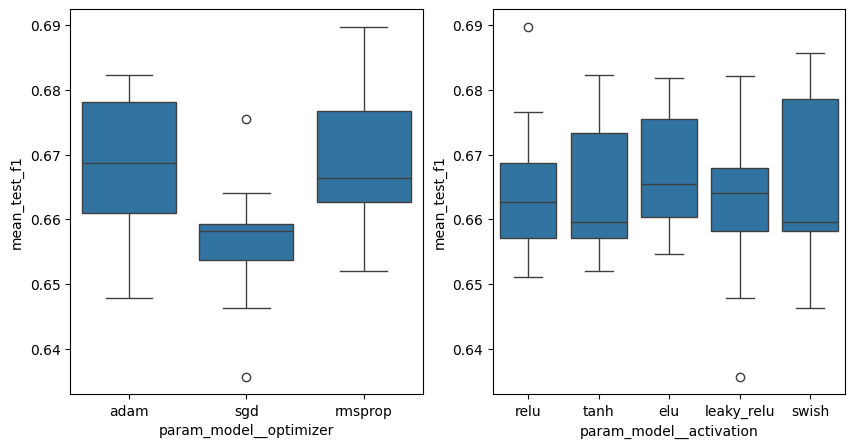

In [110]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results, x='param_model__optimizer', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results, x='param_model__activation', y='mean_test_f1', ax=ax[1])


In [111]:
keras_scores_test

,accuracy,precision,recall,f1
0,0.757966,0.716894,0.685655,0.695567
1,0.759322,0.694023,0.673338,0.680037
2,0.763908,0.714067,0.675484,0.687293


In [113]:
keras_estimators

[KerasClassifier(
 	model=<function create_model at 0x0000016D5FF93BA0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=relu
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x0000016D5FF93BA0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=tanh
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_mode

In [118]:
keras_class_param_2 = {
    'batch_size': [10],
    'epochs': [10],     
    'model__optimizer': ['rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'leaky_relu', 'swish'], 
    'model__loss': ['sparse_categorical_crossentropy'],
    'model__layers': [1, 2, 3],
    'model__neurons': [80],
}
keras_class_model_2 = KerasClassifier(model=create_model, verbose=0)
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_class_model_2, keras_class_param_2, outer_splits=3, inner_splits=2)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

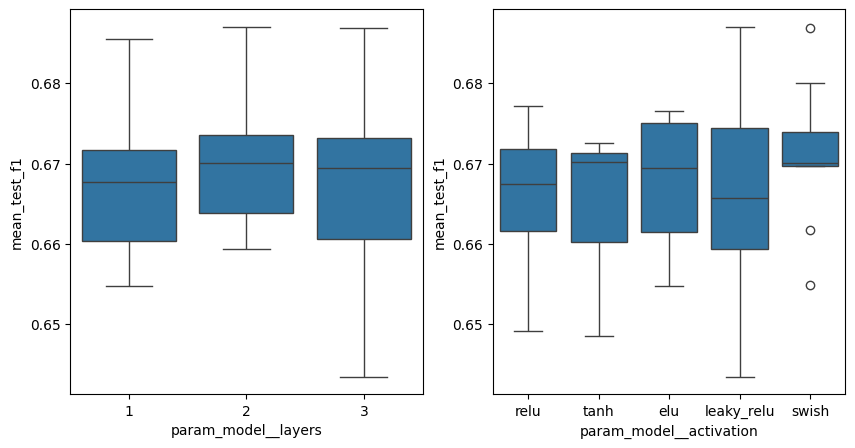

In [120]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_2, x='param_model__layers', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_2, x='param_model__activation', y='mean_test_f1', ax=ax[1])

In [121]:
keras_scores_test_2

,accuracy,precision,recall,f1
0,0.752542,0.691519,0.680938,0.685301
1,0.756610,0.692469,0.673387,0.679211
2,0.764586,0.703474,0.673878,0.680476


In [122]:
keras_scores_train_2

,accuracy,precision,recall,f1
0,0.819939,0.778989,0.759380,0.767472
1,0.818583,0.784137,0.750551,0.762638
2,0.841017,0.829381,0.774819,0.792299


In [123]:
keras_estimators_2

[KerasClassifier(
 	model=<function create_model at 0x0000016D9A495C60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=leaky_relu
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x0000016D9A495C60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=tanh
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function cr